<a href="https://colab.research.google.com/github/Snehithakatha/WEEK-2/blob/main/garbagecollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras


In [10]:
dataset_dir = r"/content/drive/MyDrive/TrashType_Image_Dataset"
# Changed from (124, 124) to (256, 256)
image_size = (256, 256)
batch_size = 32
seed = 42

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 18 files belonging to 1 classes.
Using 15 files for training.
Found 18 files belonging to 1 classes.
Using 3 files for validation.


In [12]:
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
split_index = max(1, val_batches // 2)  # Prevents test_ds from being empty

test_ds = val_ds.take(split_index)
val_dat = val_ds.skip(split_index)

test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)
val_dat = val_dat.cache().prefetch(tf.data.AUTOTUNE)

In [13]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Flatten all labels into a single array
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

# Compute class weights
class_weight_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weight_array)}

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2)
])

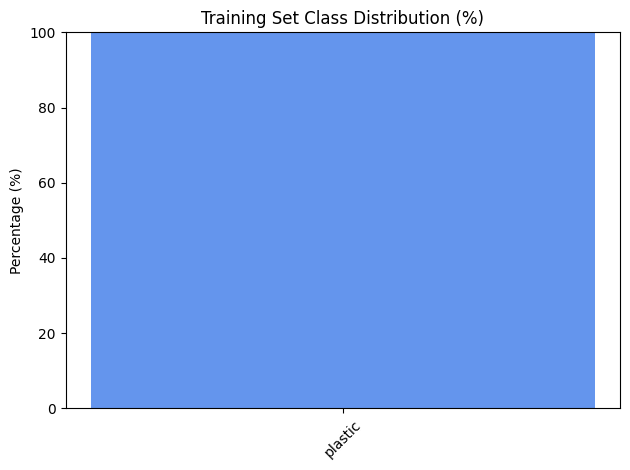

In [15]:
# Count percentage distribution
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1
    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

# Plot distribution
def simple_bar_plot(dist, title):
    import matplotlib.pyplot as plt
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

train_dist = count_distribution(train_ds, train_ds.class_names)
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")